<a href="https://colab.research.google.com/github/take2rohit/denoising_autoencoder/blob/master/benchmark_ICRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/ruphan/OrigamiDataset
# !git clone https://gitlab.com/take2rohit/dataset_origami_combined.git
# !git clone https://github.com/take2rohit/denoising_autoencoder.git 
# !rm -rf OrigamiDataset

Cloning into 'OrigamiDataset'...
remote: Enumerating objects: 1438, done.
remote: Counting objects: 100% (1438/1438), done.
remote: Compressing objects: 100% (1437/1437), done.
remote: Total 111711 (delta 1), reused 1438 (delta 1), pack-reused 110273
Receiving objects: 100% (111711/111711), 1.26 GiB | 38.61 MiB/s, done.
Resolving deltas: 100% (28/28), done.
Checking out files: 100% (91628/91628), done.


In [ ]:
 # get helper files and dataset
#importing the necessary packages
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2
import os
import json
from itertools import combinations
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import random

# From custom helper
# from DAE_dataset_helper import OrigamiDatasetGenerate,ValidationGenerate
# from DAE_dataset_helper import ToTensor,Resize, Normalize,AddNoise,RandomBackground
# from DAE_dataset_helper import ToTensorValidate,NormalizeValidate,ResizeValidate

# Dataset Loading, Visualising and Architecture design 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cv2
import numpy as np,os

class AddNoise(object):
    def __init__(self, mean, var, noise_typ = "gauss"):
        self.noise_typ = noise_typ
        self.mean = mean 
        self.var = var
    
    def __call__(self, sample):
        original, augmented = sample['original'], sample['augmented']

        if self.noise_typ == "gauss":
            row,col,ch= augmented.shape
            mean = self.mean
            var = self.var
            sigma = var**0.5
            gauss = np.random.normal(mean,sigma,(row,col,ch))
            gauss = gauss.reshape(row,col,ch)
            noisy = noisy = np.clip(augmented + gauss, 0,1)

        if self.noise_typ == "s&p":
            row,col,ch = augmented.shape
            s_vs_p = self.mean
            amount = self.var
            out = np.copy(augmented)
            # Salt mode
            num_salt = np.ceil(amount * augmented.size * s_vs_p)
            coords = [np.random.randint(0, i - 1, int(num_salt))
                    for i in augmented.shape]
            out[coords] = 255

            # Pepper mode
            num_pepper = np.ceil(amount* augmented.size * (1. - s_vs_p))
            coords = [np.random.randint(0, i - 1, int(num_pepper))
                    for i in augmented.shape]
            out[coords] = 0
            noisy = out
        
        return {'original': original,
                'augmented': noisy,
                'dof_vec' : sample['dof_vec'],
                'img_name' :sample['img_name']}    

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        original, augmented = sample['original'], sample['augmented']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        original = np.transpose(original, (2, 0, 1))
        augmented = np.transpose(augmented, (2, 0, 1))
        return {'original': torch.from_numpy(original).float(),
                'augmented': torch.from_numpy(augmented).float(),
                'dof_vec' : torch.from_numpy(sample['dof_vec']).float(),
                'img_name' :sample['img_name']}

class Resize(object):
    """ndarrays resize."""
    
    def __init__(self, size):
        self.size = size
        
    def __call__(self, sample):
        original, augmented = sample['original'], sample['augmented']
        
        original = cv2.resize(original, dsize=self.size, interpolation=cv2.INTER_CUBIC)
        original = np.expand_dims(original, axis=2)

        augmented = cv2.resize(augmented, dsize=self.size, interpolation=cv2.INTER_CUBIC)

        return {'original': original, 
                'augmented':augmented,
                'dof_vec' : sample['dof_vec'],
                'img_name' :sample['img_name']}

class RandBrightness(object):
    """add random brightness."""    
    def __init__(self,bright):
        self.bright = bright

    def __call__(self, sample):
        original, augmented = sample['original'], sample['augmented']
        
        augmented = augmented * self.bright
        augmented = np.clip(augmented,0,1)

        return {'original': original, 
                'augmented':augmented, 
                'dof_vec' : sample['dof_vec'],
                'img_name' :sample['img_name']}

class Normalize(object):
    
    def __call__(self, sample):
        original, augmented = sample['original'], sample['augmented']
        
        min_noisy,max_noisy = np.min(original),np.max(original)
        original = (original - min_noisy)/(max_noisy-min_noisy)
        
        min_noisy,max_noisy = np.min(augmented),np.max(augmented)
        augmented = (augmented - min_noisy)/(max_noisy-min_noisy)
        return {'original': original, 
                'augmented':augmented,
                'dof_vec' : sample['dof_vec'],
                'img_name' :sample['img_name']}
 
class Occluder(object):
    def __init__(self, percent_occ):
        self.percent_occ = percent_occ

    def __call__(self,sample):
        original, augmented = sample['original'], sample['augmented']
        

        sample_colour = augmented[np.random.randint(0,high=128)][np.random.randint(0,high=128)]
        white_px = cv2.countNonZero(original)
        req_white_px = round(white_px * self.percent_occ/100)
        max_val = np.max(original)
        # r, c = np.where(original)
        row_white_px,col_white_px = [],[]
        for i in range(128):
            for j in range(128):
                if req_white_px == 0:
                    break
                if original[i][j] == max_val:
                    req_white_px-= 1
                    row_white_px.append(i)
                    col_white_px.append(j)
            
        min_x,min_y = min(col_white_px), min(row_white_px)
        max_x,max_y = max(col_white_px), max(row_white_px)

        augmented = cv2.rectangle(augmented,(min_x,min_y),(max_x,max_y),tuple(sample_colour),-1)

        return {'original': original, 
            'augmented':augmented,
            'dof_vec' : sample['dof_vec'],
            'img_name' :sample['img_name']}

In [ ]:
class DataLoadResUnet(Dataset):
    '''
    Change self.dataset_size to set custom dataset size for testing
    If u have direct input and output labels use set complete_ip=True
       @param bg_dir = input images
       @param origami_dir = output image
    '''
    def __init__(self, origami_dir, bg_dir, csv_dir,complete_ip=False, 
                 percent_occ=0,dataset_size=150,transform=None):
        self.bg_dir = bg_dir
        self.origami_dir = origami_dir
        self.transform = transform
        self.dataset_size=dataset_size
        self.dframe = pd.read_csv(csv_dir)
        self.complete_ip = complete_ip
        self.percent_occ = percent_occ
        self.orgami_list = [f for f in os.listdir(self.origami_dir) \
         if os.path.isfile(os.path.join(self.origami_dir, f))]
        
        # self.dataset_size=1000
        self.dataset_size = len(self.orgami_list)
        
        self.bg_list = [f for f in os.listdir(self.bg_dir) \
         if os.path.isfile(os.path.join(self.bg_dir, f))]

    def rand_rotate_flip(self, img):
        flip = [0,1,-1]
        rotate =[cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
        img = cv2.rotate(img, random.choice(rotate))
        img = cv2.flip(img, random.choice(rotate))
        return img 

    def merge(self,origami_loc, background_loc):
        origami = cv2.imread(origami_loc)
        origami_black_bg = origami.copy()
        background = cv2.imread(background_loc)
        background = cv2.resize(background, dsize=(origami.shape[0],origami.shape[1]), 
                                interpolation=cv2.INTER_CUBIC)
        background = self.rand_rotate_flip(background)
        frame_threshold = cv2.inRange(cv2.cvtColor(origami, cv2.COLOR_BGR2HSV), (50, 50, 50), (70, 255, 255))
        temp1 = cv2.bitwise_and(origami_black_bg, origami_black_bg, mask=cv2.bitwise_not(frame_threshold))
        temp2 = cv2.bitwise_and(background, background, mask=frame_threshold)
        out_image = cv2.bitwise_not(frame_threshold)
        
        in_image = cv2.bitwise_or(temp1, temp2)
        in_image = cv2.cvtColor(in_image, cv2.COLOR_BGR2RGB)
        return in_image,out_image

    
    def __len__(self):
        return self.dataset_size
    
    def __getitem__(self, idx):

        idx_org = idx

        if not self.complete_ip:
            idx_bg = np.random.randint(1,len(self.bg_list))-1
            
            greenScreen_origami_path = os.path.join(self.origami_dir,
                                    self.orgami_list[idx_org])

            bg_img_path = os.path.join(self.bg_dir,
                                    self.bg_list[idx_bg])            
        
            origami_merged, origami_black_bg = self.merge(greenScreen_origami_path,bg_img_path)
        else:
            greenScreen_origami_path = os.path.join(self.origami_dir,
                                    self.orgami_list[idx_org])

            bg_img_path = os.path.join(self.bg_dir,
                                    self.bg_list[idx_org])

            origami_merged = cv2.imread(bg_img_path)
            origami_merged = cv2.cvtColor(origami_merged, cv2.COLOR_BGR2RGB)
            origami_black_bg = cv2.imread(greenScreen_origami_path,0)
        
        dof_vec = self.dframe[self.dframe['Img_Name']==self.orgami_list[idx]].values[0]

        sample = {'augmented': origami_merged, 
                  'original': origami_black_bg,
                  'dof_vec' : dof_vec[1:7].astype(float),
                  'img_name' : self.orgami_list[idx_org]}

        if self.transform:
            sample = self.transform(sample)
        return sample


[GPU NAME] Tesla T4

Training dataset size: 3        Testing dataset size: 297
Input to network


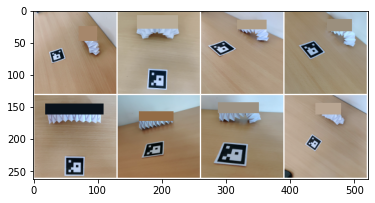

Output of network (To be verified with)


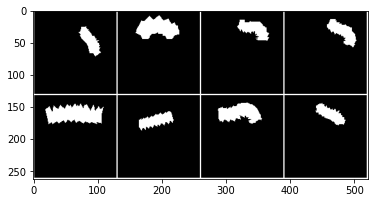

In [ ]:
train_batch_size = 32
test_batch_size = 32
split_percent = 0.01

# random_background_dir = "/content/OrigamiDataset/Omega/omega_real/input_images"
# origami_dataset_dir = '/content/OrigamiDataset/Omega/omega_real/output_images'
# csv_dir = '/content/OrigamiDataset/Omega/omega_real_pose.csv'

# origami_dataset_dir = '/content/dataset_origami_combined/all_merged'
# random_background_dir = "/content/OrigamiDataset/background_images"
# csv_dir = '/content/dataset_origami_combined/pose.csv'


random_background_dir = '/content/OrigamiDataset/finetuning_combined_dataset/input_images'
origami_dataset_dir = '/content/OrigamiDataset/finetuning_combined_dataset/output_images'
csv_dir = '/content/OrigamiDataset/finetuning_combined_dataset/pose.csv'

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

print(f'\n[GPU NAME] {torch.cuda.get_device_name(device)}\n')
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

trns = transforms.Compose([Resize((128,128)),Normalize(),Occluder(50), #RandBrightness(2),
                           ToTensor()])
# ,RandBrightness(),AddNoise(0,0.001),
origami = DataLoadResUnet(origami_dataset_dir,random_background_dir,csv_dir, transform=trns,
                           percent_occ=50,complete_ip=True)

train_size = int(split_percent * len(origami))
test_size = abs(len(origami) - train_size)
train_dataset, test_dataset = torch.utils.data.random_split(origami, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=train_batch_size,
                            shuffle=True,**kwargs)

test_loader = DataLoader(test_dataset, batch_size=test_batch_size,
                            shuffle=False,**kwargs)

print(f'Training dataset size: {len(train_dataset)} \
       Testing dataset size: {len(test_dataset)}')


iterator = iter(test_loader)
sample = iterator.next()
augmented,original, dof_vec = sample['augmented'],sample['original'], sample['dof_vec']

def imshow(img, images_show = 8,ret_img=False):
    kwargs =  {'nrow':4, "padding":2, "pad_value":1}
    img = torchvision.utils.make_grid(img[:images_show,:], **kwargs)
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg)
    plt.show()
    if ret_img:
        return npimg

print('Input to network')
imshow(augmented)
print('Output of network (To be verified with)')
imshow(original)

### Model File

In [ ]:
#defining the resunet model in pytorch

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels), 
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels), 
        nn.ReLU(inplace=True)
    )

def root_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels), 
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels), 
    )   

# Define the ResNetUNet architecture
class ResNetUNet(nn.Module):

    def __init__(self, n_class=1):
        super().__init__()
        
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down11 = root_block(64, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down21 = root_block(128, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down31 = root_block(256, 256)
        self.dconv_down4 = double_conv(256, 512)
        self.dconv_down41 = root_block(512, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.relu = nn.ReLU(inplace=True)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up31 = root_block(256, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up21 = root_block(128, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        self.dconv_up11 = root_block(64, 64)

        self.conv_last = nn.Conv2d(64, n_class, 1)

        self.onebyoneconv = nn.Conv2d(512,1,1)
        self.maxpool_lin = nn.MaxPool2d(4)
        # self.linear1 = nn.Linear(8192,1024)
        # self.linear2 = nn.Linear(1024, 6)
        self.linear1 = nn.Linear(256, 6)



    def forward(self, x):
        # print('image: ', x.shape)
        conv1 = self.dconv_down1(x)
        # print('double_conv1 ', conv1.shape)
        x = self.dconv_down11(conv1)
        # print('dconv_down11 ', x.shape)
        x += conv1
        # print('dconv_down11 + double_conv1')
        x = self.relu(x)
        # print('relu ', x.shape)
        x = self.maxpool(x)
        # print('maxpool', x.shape, '\n')
        
        conv2 = self.dconv_down2(x)
        # print('double_conv2 ', conv2.shape)
        x = self.dconv_down21(conv2)
        # print('dconv_down21 ', x.shape)
        x += conv2
        # print('conv2 + dconv_down21')
        x = self.relu(x)
        # print('relu ', x.shape)
        x = self.maxpool(x)
        # print('maxpool', x.shape, '\n')

        conv3 = self.dconv_down3(x)
        # print('double_conv3 ', conv3.shape)
        x = self.dconv_down31(conv3)
        # print('dconv_down31 ', x.shape)
        x += conv3
        # print('conv3 + dconv_down31')
        x = self.relu(x)
        # print('relu ', x.shape)
        x = self.maxpool(x)
        # print('maxpool', x.shape, '\n')

        conv4 = self.dconv_down4(x)
        # print('double_conv4 ', conv4.shape)
        x = self.dconv_down41(conv4)
        # print('root ', x.shape)
        x += conv4
        x = self.relu(x)        # op: [N, 512, 16, 16]
        # print('relu ', x.shape,'\n #############')

        ######### latent variable #########

        # latent = self.maxpool_lin(x)
        latent = self.onebyoneconv(x)
        flat = latent.reshape((int(latent.shape[0]),-1))
        y = self.linear1(flat)
        # y = self.relu(y)
        # y = self.linear2(y)
        # y = self.relu(y)

        dof = y
 
        ####################


        deconv3 = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        # print('deconv3: ', deconv3.shape)
        deconv3 = torch.cat([deconv3, conv3], dim=1)
        # print('cat:deconv3, conv3 ', deconv3.shape)
        uconv3 = self.dconv_up3(deconv3)
        # print('uconv3: ', uconv3.shape)

        x = self.dconv_up31(uconv3)
        # print('dconv_up31: ', x.shape)

        x += uconv3
        x = self.relu(x)
        # print('relu: ', x.shape)

        deconv2 = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        # print('deconv2: ', deconv2.shape)
        deconv2 = torch.cat([deconv2, conv2], dim=1)
        # print('deconv2: ', deconv2.shape)

        uconv2 = self.dconv_up2(deconv2)
        # print('deconv2 up: ', uconv2.shape)
        x = self.dconv_up21(uconv2)
        # print('dconv up: ', x.shape)

        x += uconv2
        x = self.relu(x)
        # print('relu: ', x.shape)


        deconv1 = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        # print('deconv1: ', deconv1.shape)
        deconv1 = torch.cat([deconv1, conv1], dim=1)
        # print('cat: ', deconv1.shape)
        uconv1 = self.dconv_up1(deconv1)
        # print('uconv1: ', uconv1.shape)

        x = self.dconv_up11(uconv1)
        # print('x: ', x.shape)

        x += uconv1
        x = self.relu(x)
        # print('relu ', x.shape)

        out = self.conv_last(x)
        # print('convlast ', out.shape)

        out = self.tanh(out)
        # print('tanh ', out.shape)

        return out,dof
from torchsummary import summary

model = ResNetUNet().to('cuda')
# summary(model, input_size=(3, 128, 128))

# out, dof = model.forward(torch.randn(17,3,128,128).to('cuda'))
# params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f'learnable parameters: {params:,d}')

#  Binary Dice Loss



In [ ]:
class BinaryDiceLoss(nn.Module):
    """Dice loss of binary class
    Args:
        smooth: A float number to smooth loss, and avoid NaN error, default: 1
        p: Denominator value: \sum{x^p} + \sum{y^p}, default: 2
        predict: A tensor of shape [N, *]
        target: A tensor of shape same with predict
        reduction: Reduction method to apply, return mean over batch if 'mean',
            return sum if 'sum', return a tensor of shape [N,] if 'none'
    Returns:
        Loss tensor according to arg reduction
    Raise:
        Exception if unexpected reduction
    """
    
    def __init__(self, smooth=1, p=2, reduction='mean'):
        super(BinaryDiceLoss, self).__init__()
        self.smooth = smooth
        self.p = p
        self.reduction = reduction

    def forward(self, predict, target):
        assert predict.shape[0] == target.shape[0], "predict & target batch size don't match"
        predict = predict.contiguous().view(predict.shape[0], -1)
        target = target.contiguous().view(target.shape[0], -1)

        num = torch.sum(torch.mul(predict, target), dim=1) + self.smooth
        den = torch.sum(predict.pow(self.p) + target.pow(self.p), dim=1) + self.smooth

        loss = 1 - num / den

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        elif self.reduction == 'none':
            return loss
        else:
            raise Exception('Unexpected reduction {}'.format(self.reduction))

# Training Helper files

In [ ]:
def train_nn_unet(model, device, train_loader, optimizer, loss_formula, epoch,log_interval=20):
    global store_train_loss
    model.train()
    l2 = nn.L1Loss()
    alpha = 20
    for batch_idx, sample in enumerate(train_loader):
        data, target, dof = sample['augmented'],sample['original'], sample['dof_vec']
        data, target, dof = data.to(device), target.to(device), dof.to(device)
        optimizer.zero_grad()
        reconst, dof_estimate = model(data)
        
        recons_loss = loss_formula(reconst, target)
        dof_loss = alpha * l2(dof, dof_estimate)
        
        
        loss =  recons_loss +  dof_loss
        # loss = recons_loss + dof_loss
        loss.backward()
        
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} \tTotal Loss: {:.6f} \tRecons_loss Loss: {:.6f} \tdof_loss Loss: {:.6f}'.format(epoch,loss.item(),recons_loss.item(), dof_loss.item()))
    
    store_train_loss.append([epoch,loss.item()])


def loss_plotter(store_train_loss, store_test_loss, epoch, location):
    store_train_loss= np.array(store_train_loss)
    store_test_loss= np.array(store_test_loss)
    plt.plot(store_train_loss[:,0], store_train_loss[:,1], label='Train Loss')
    plt.plot(store_test_loss[:,0], store_test_loss[:,1], label='Test Loss')
    plt.legend()
    plt.savefig(os.path.join(location,'plots',f'plot_{epoch}.png'))
    plt.show()

def imshow_saver(data, reconst,save_img_name, images_show = 8,viewer=True):
    '''
    Construct a grid for both reconstruction and input image values
    Also save them with filename save_img_name
    '''
    kwargs =  {'nrow':4, "padding":2, "pad_value":1}

    img = torchvision.utils.make_grid(data[:images_show,:], **kwargs)
    npimg = img.cpu().numpy()
    data_np = np.transpose(npimg, (1, 2, 0))

    img = torchvision.utils.make_grid(reconst[:images_show,:], **kwargs)
    npimg = img.cpu().numpy()
    reconst_np = np.transpose(npimg, (1, 2, 0))

    cat = np.vstack((data_np,reconst_np))
    cat = np.clip(cat, 0, 1)
    plt.imsave(save_img_name, cat)
    if viewer:
        plt.imshow(cat)
        plt.show()

def google_drive_store(root, save_model_name, load_saved_model = True):
    '''
    Saves all model file, intermediate results and plots on drive location. 
    It will create folder as well. Make sure to mount drive before
    @param- saved_model_pth: save ur model with with this name 
            if already exsists, load these weights
    @param- load_saved_model: bool-Load saved model ?

    '''
    # root = '/content/drive/My Drive/RohitEeChianNUSTeleinternGamitrack/denoising_ae_colab/gs_haptic3'
    # save_model_name = "gs_haptic3.pt"

    ### Create folders if not exists
    saved_model_pth = os.path.join(os.path.join(root,save_model_name))
    if os.path.exists(saved_model_pth) and load_saved_model:
        model.load_state_dict(torch.load(saved_model_pth, map_location='cuda:0'))
        print(f"[MODEL loaded] {saved_model_pth}")
   
    if not os.path.exists(root):
        os.mkdir(root)
        print(f'[Path Created] {root}')

    if not os.path.exists(os.path.join(root,'plots')):
        os.mkdir(os.path.join(root,'plots'))
        print('[Path Created] ', os.path.join(root,'plots'))
    
    val_img_save_folder = os.path.join(root,'validation_results')
    if not os.path.exists(val_img_save_folder):
        os.mkdir(val_img_save_folder)
        print(f'[Path Created] {val_img_save_folder}')


def test(model, device, test_loader,loss_formula,save_img=False,ep=None,save_folder=None):
    model.eval()
    global store_test_loss 
    test_loss, recons_loss, dof_loss = 0,0,0
    correct = 0
    l2 = nn.L1Loss()
    alpha = 20

    with torch.no_grad():
        for c, sample in enumerate(test_loader):
            data, target, dof = sample['augmented'],sample['original'], sample['dof_vec']
            data, target, dof = data.to(device), target.to(device), dof.to(device)
            reconst, dof_estimate = model(data)
            
            recons_loss +=  loss_formula(reconst, target)
            dof_loss += alpha  * l2(dof, dof_estimate)
                # print('Break')
        
        test_loss = recons_loss + dof_loss

            # test_loss += loss_formula(reconst,target) + l2(dof, dof_estimate) # sum up batch loss
    test_loss /= max(1,c)
    recons_loss /= max(1,c)
    dof_loss /= max(1,c)

    print('\nTest set: Avg loss: {:.4f} Recons_loss \
    Loss: {:.6f}\tdof_loss Loss: {:.6f}'.format(test_loss,recons_loss, dof_loss))
    imshow(data.cpu())
    imshow(reconst.cpu())
    store_test_loss.append([ep,(test_loss).item()])
    
    if save_img:
        imshow_saver(data, reconst,os.path.join(save_folder,f'epoch_{ep}.png'),
                     images_show = 8)
        print('image saved')
    print('done')



Test set: Avg loss: 13.3562 Recons_loss     Loss: 0.966593	dof_loss Loss: 12.389571


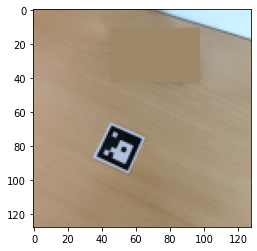

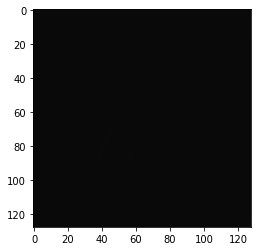

done


In [ ]:

trns = transforms.Compose([Resize((128,128)),Normalize(), Occluder(100),
                            ToTensor()])
origami_val = DataLoadResUnet(origami_dataset_dir,random_background_dir,
                        csv_dir, transform=trns,complete_ip=True)

benchmark_loader = DataLoader(origami_val, batch_size=1,
                    shuffle=False,**kwargs)

store_test_loss = []
test(model, device, benchmark_loader, BinaryDiceLoss())

# Validate

In [ ]:
class ToTensorValidate(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        sample = np.transpose(sample, (2, 0, 1))
        return torch.from_numpy(sample)

class ResizeValidate(object):
    """ndarrays resize."""
    
    def __init__(self, size):
        self.size = size
        
    def __call__(self, sample):
        sample = cv2.resize(sample, dsize=self.size, interpolation=cv2.INTER_CUBIC)
        return sample

class NormalizeValidate(object):
    
    def __call__(self, sample):   
        
        min_noisy,max_noisy = np.min(sample),np.max(sample)
        sample = (sample - min_noisy)/(max_noisy-min_noisy)
        
        return sample



In [ ]:
import re 

class ValidationGenerate(Dataset):

    def __init__(self, root_dir,transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.all_image_filenames = [f for f in os.listdir(self.root_dir) \
         if os.path.isfile(os.path.join(self.root_dir, f))]
        self.all_image_filenames.sort(key=lambda f: int(re.sub('\D', '', f)))
    def __len__(self):
        return len(self.all_image_filenames)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        inp_img_path = os.path.join(self.root_dir,
                                self.all_image_filenames[idx])
        sample = cv2.imread(inp_img_path)  
        sample = cv2.cvtColor(sample,cv2.COLOR_BGR2RGB)     
        if self.transform:
            sample = self.transform(sample)

        return sample,inp_img_path

def save_as_csv(arr, savefile):
    '''
    Convert rodrigues form to rot matrix
    '''
    if os.path.exists(savefile):
        os.remove(savefile)
    if torch.is_tensor(arr):
        arr = np.array(arr.cpu())
    for a in arr:
        rvec = a[3:]
        rot = cv2.Rodrigues(rvec)
        res = rot[0].reshape((1,9)).squeeze()
        
        r = f'{res[0]},{res[1]},{res[2]},{res[3]},{res[4]},{res[5]},{res[6]},{res[7]},{res[8]}'
        t = f'{a[0]},{a[1]},{a[2]},'
        stg = t + r + '\n'
        with open(savefile,'a') as f:
            f.write(stg)
    print('Files saved to be used in Rhino!')


In [ ]:
# df = pd.read_csv('/content/omega_real_pose.csv')
# arr = []
# for i in df.index:
#     arr.append([df['Tx'][i],df['Ty'][i],df['Tz'][i],df['Rx'][i],df['Ry'][i],df['Rz'][i]])
# arr = np.array(arr)
# save_as_csv(arr, 'omega_real_pose_rotation_mat.csv')

In [ ]:
def cross_validation(model, device, test_loader,ep = None, viewer=True, save_folder =None):
    model.eval()
    test_loss = 0
    correct = 0
    images_show = 8
    kwargs =  {'nrow':4, "padding":2, "pad_value":1}

    with torch.no_grad():
        validator = iter(test_loader)
        sample,inp_img_path = next(validator)
        print(f'sample: {inp_img_path}')
        sample = sample.to(device).float()
        
        output, dof_estimate = model(sample)
        op = output[:images_show,:].cpu()
        tar = sample[:images_show,:].cpu()

    if viewer:
        print('Reconstructed')
        imshow(torchvision.utils.make_grid(op,**kwargs))
        print('Input to Netowrk')
        tar = sample[:images_show,:].cpu()
        imshow(torchvision.utils.make_grid(tar, **kwargs))  
    
    if save_folder is not None:
        imshow_saver(tar, op,'validation.png', images_show = 8,viewer=False)
    
    if save_folder is not None and ep is not None:
        imshow_saver(tar, op,os.path.join(save_folder, f'validation_{ep}.png'), 
                     images_show = 8,viewer=False)
        
    return sample, output, dof_estimate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Loading and inferening model
model = ResNetUNet().to(device)
val_directories = {'inch': '/content/drive/My Drive/ResUNET/utility_dataset_images/inchworm_poseless',
                   'omega': '/content/drive/My Drive/ResUNET/utility_dataset_images/omega_poseless',
                   'omega_old': '/content/drive/My Drive/ResUNET/utility_dataset_images/omega_poseless_old',
                   'omega_real': '/content/drive/My Drive/ResUNET/utility_dataset_images/omega_real',
                   'standard': '/content/drive/My Drive/ResUNET/utility_dataset_images/standard_poseless',
                   'occlusion': '/content/drive/My Drive/ResUNET/utility_dataset_images/occlusion'
                   }

origami_validate_dir = val_directories['omega_real']

root = '/content/drive/My Drive/ResUNET/benchmark'
# save_model_name = "savedModel.pt"
save_model_name = "finalModel.pt"

val_img_save_folder = os.path.join(root,'validation_results')
saved_model_pth = os.path.join(root,save_model_name)
google_drive_store(root,saved_model_pth, load_saved_model = True)

use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

trns = transforms.Compose([ResizeValidate((128,128)), NormalizeValidate(), Occluder(50), ToTensorValidate() ])
validator = ValidationGenerate(root_dir=origami_validate_dir, transform=trns)

val_batch_size = 8
val_loader = DataLoader(validator, batch_size=val_batch_size,
                            shuffle=False,**kwargs)


if not os.path.exists(saved_model_pth):
    print('saved file not found! Exitting..')

else:
    # print(f'[Model Loaded] {saved_model_pth}\n Running Inference...')
    model.load_state_dict(torch.load(saved_model_pth, map_location='cuda:0'))
    sample, output, dof_estimate = cross_validation(model, device, val_loader,
                                                save_folder = val_img_save_folder)


    # save_as_csv(dof_estimate,'pose.csv')

[MODEL loaded] /content/drive/My Drive/ResUNET/benchmark/finalModel.pt


IndexError: ignored

# Benchmarking

In [ ]:
def benchmark(model, device, test_loader,loss_formula,save_img=False,ep=None,save_folder=None,save_estimated_pose='estimated_pose.csv'):
    model.eval()
    global store_test_loss 
    test_loss, recons_loss, dof_loss = 0,0,0
    correct = 0
    l2 = nn.L1Loss()
    alpha = 20
    list_test_loss, list_recons_loss, list_dof_loss = [],[],[]
    if os.path.exists(save_estimated_pose):
        os.remove(save_estimated_pose)
    with torch.no_grad():
        
        for c, sample in enumerate(test_loader):
            data, target, dof = sample['augmented'],sample['original'], sample['dof_vec']
            img_name = sample['img_name']

            data, target, dof = data.to(device), target.to(device), dof.to(device)
            reconst, dof_estimate = model(data)
            # dof_np = np.array(dof_estimate.cpu())

            # list_recons_loss.append(loss_formula(reconst, target))
            recons_loss +=  loss_formula(reconst, target)
            dof_loss += alpha  * l2(dof, dof_estimate)
            test_loss = recons_loss + dof_loss
            mean_abs_error = abs(dof_estimate - dof).cpu()
            
            # test_loss += loss_formula(reconst,target) + l2(dof, dof_estimate) # sum up batch loss
    recons_loss /= max(1,c)
    test_loss /= max(1,c)
    dof_loss /= max(1,c)

    # dic = {'name' : img_name, 
    #         'Tx': dof_np[:,0],'Ty': dof_np[:,1],'Tz': dof_np[:,2],
    #         'Rx': dof_np[:,3],'Ry': dof_np[:,4],'Rz': dof_np[:,5]}
        
    # df = pd.DataFrame(dic) 
    # df.to_csv(save_estimated_pose, mode='a',index=False, header=False)

    # print('\nTest set: Avg loss: {:.4f} Recons_loss \
    # Loss: {:.6f}\tdof_loss Loss: {:.6f}'.format(test_loss,recons_loss, dof_loss))
    # imshow(reconst.cpu())
    # imshow(target.cpu())
    # store_test_loss.append([ep,(test_loss).item()])
    
    if save_img:
        imshow_saver(data, reconst,os.path.join(save_folder,f'epoch_{ep}.png'),
                     images_show = 8)
        print('image saved')


    return  mean_abs_error.squeeze().tolist(), [float(recons_loss)]
    # with open("test.txt", "a") as f:
    #     f.write("\n")
    # f = "test.txt"
    # if os.path.exists(f):
    #     os.remove(f)
    # np.savetxt(f, list_recons_loss)

dice_loss = BinaryDiceLoss()
store_train_loss = []
store_test_loss = []
torch.cuda.empty_cache()


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

print(f'\n[GPU NAME] {torch.cuda.get_device_name(device)}\n')
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# trns = transforms.Compose([Resize((128,128)),Normalize(), RandBrightness(0.2),
#                            Occluder(), ToTensor()])


random_background_dir= '/content/OrigamiDataset/finetuning_combined_dataset/input_images'
origami_dataset_dir = "/content/OrigamiDataset/finetuning_combined_dataset/output_images"
csv_dir = '/content/OrigamiDataset/finetuning_combined_dataset/pose.csv'



model.load_state_dict(torch.load(saved_model_pth, map_location='cuda:0'))

# sample, output, dof_estimate = test(model, device, benchmark_loader,
#                                                 save_folder = val_img_save_folder)

min_brightness, max_brightness = 0, 3
brightness_step = 0.1

min_occlusion, max_occlusion = 1,99
occlusion_step = 1

combined_list4csv = []

brightness = 0


while brightness < max_brightness:
    brightness+= brightness_step
    occlusion = 0

    while occlusion < max_occlusion:
        occlusion += occlusion_step
        
        trns = transforms.Compose([Resize((128,128)),Normalize(),
                                   RandBrightness(brightness),Occluder(occlusion),
                                    ToTensor()])
        
        origami_val = DataLoadResUnet(origami_dataset_dir,random_background_dir,
                                csv_dir, transform=trns,complete_ip=True)
        
        benchmark_loader = DataLoader(origami_val, batch_size=1,
                            shuffle=False,**kwargs)
        
        mean_abs_error, recons_loss= benchmark(model, device, benchmark_loader,
                                                dice_loss, save_folder=root)


        combined_list4csv.append([occlusion] + [brightness]+mean_abs_error+recons_loss)
        print(f'[Brightness: {brightness:.2f} \t Occlusion: {occlusion:.2f}]', mean_abs_error+recons_loss)

        # print(occlusion, occlusion_step,brightness,  brightness_step)

df = pd.DataFrame(combined_list4csv,
                    columns=['Occlusion','Brightness','Tx','Ty','Tz','Rx','Ry','Rz','reconst'])
df.to_csv('3dplot.csv' , index=False)


NameError: ignored

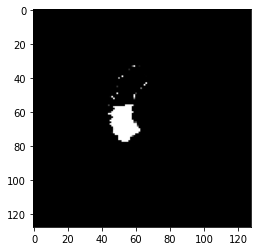

In [ ]:
# import cv2
# def occluder(im, percent_occ):

#     frame_threshold = cv2.inRange(cv2.cvtColor(im, cv2.COLOR_BGR2HSV), (50, 50, 50), (70, 255, 255))
#     frame_threshold = cv2.bitwise_not(frame_threshold)
#     frame_threshold = cv2.resize(frame_threshold, dsize=(128,128), 
#                                 interpolation=cv2.INTER_CUBIC)

#     white_px = cv2.countNonZero(frame_threshold)
#     req_white_px = round(white_px * percent_occ/100)
#     max_val = np.max(frame_threshold)
#     for i in range(128):
#         for j in range(128):
#             if req_white_px == 0:
#                 break
#             if frame_threshold[i][j] == max_val:
#                 frame_threshold[i][j] = 0
#                 req_white_px-= 1
#     return frame_threshold

# im = cv2.imread('/content/dataset_origami_combined/all_merged/img__16751_o.png')

# occ_frame = occluder(im, 50)
# plt.imshow(occ_frame, cmap='gray')

In [ ]:
def run_sequential_inference(val_loader,frames = 1666, val_batch_size = 32):
    
    '''
    Test for videos frames!
    Return a list of DOFs for all images in val_loader
    '''
    model.eval()
    dof_values = []
    validator = iter(val_loader)

    for i in range(frames//val_batch_size):
        print(f'Batch: {i}')
        with torch.no_grad():
            sample,inp_img_path = next(validator)
            # print(f'sample: {inp_img_path}')
            sample = sample.to(device).float()
            output, dof_estimate = model(sample)
            dof_values.append(np.array(dof_estimate.to('cpu')))
            ret_img = imshow(output.cpu(),ret_img=True)
            ret_img = np.clip(ret_img, 0,1)
            plt.imsave(f'segmented_masks_s/batch_{i}.png',ret_img)
        
        # break
    arr = np.concatenate(dof_values, axis=0)
    # print(arr)

    return arr 

# l = len(list(os.listdir('/content/images_s')))
# arr = run_sequential_inference(val_loader,frames = l, val_batch_size = 8)
# save_as_csv(arr,'test_pose_real_origami_s.csv')

1